In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from lxml import etree
from matplotlib.patches import Rectangle
import numpy as np
import glob

In [2]:
images = glob.glob('../input/imagelocationandsegmentation/图片定位与分割数据集/images/*.jpg')

In [3]:
len(images)

7390

In [4]:
xmls = glob.glob('../input/imagelocationandsegmentation/图片定位与分割数据集/annotations/xmls/*.xml')

In [5]:
len(xmls)

3686

In [6]:
xmls_names = [x.split('/')[-1].split('.xml')[0] for x in xmls]

In [7]:
len(xmls_names)

3686

In [8]:
images_names = [x.split('/')[-1].split('.jpg')[0] for x in images]

In [9]:
images_names[:3]

['american_pit_bull_terrier_16', 'leonberger_200', 'english_cocker_spaniel_35']

In [10]:
names = list(set(images_names)&set(xmls_names))

In [11]:
len(names)

3686

In [12]:
imgs = [img for img in images if img.split('/')[-1].split('.jpg')[0] in names]

In [13]:
len(imgs)

3686

In [14]:
imgs[:3]

['../input/imagelocationandsegmentation/图片定位与分割数据集/images/american_pit_bull_terrier_16.jpg',
 '../input/imagelocationandsegmentation/图片定位与分割数据集/images/saint_bernard_146.jpg',
 '../input/imagelocationandsegmentation/图片定位与分割数据集/images/Egyptian_Mau_164.jpg']

In [15]:
imgs[-3:]

['../input/imagelocationandsegmentation/图片定位与分割数据集/images/pomeranian_153.jpg',
 '../input/imagelocationandsegmentation/图片定位与分割数据集/images/Siamese_162.jpg',
 '../input/imagelocationandsegmentation/图片定位与分割数据集/images/saint_bernard_131.jpg']

In [16]:
imgs.sort(key=lambda x: x.split('\\')[-1].split('.jpg')[0])

In [17]:
xmls.sort(key=lambda x: x.split('\\')[-1].split('.xml')[0])

In [18]:
scal = 224

In [19]:
def to_labels(path):
    xml = open(r'{}'.format(path)).read()
    sel = etree.HTML(xml)
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [20]:
labels = [to_labels(path) for path in xmls]

In [21]:
out1_label, out2_label, out3_label, out4_label = list(zip(*labels))

In [22]:
len(out1_label), len(out2_label), len(out3_label), len(out4_label)

(3686, 3686, 3686, 3686)

In [23]:
index = np.random.permutation(len(imgs))

In [24]:
images = np.array(imgs)[index]


In [25]:
out1_label = np.array(out1_label)[index]
out2_label = np.array(out2_label)[index]
out3_label = np.array(out3_label)[index]
out4_label = np.array(out4_label)[index]

In [26]:
label_datset = tf.data.Dataset.from_tensor_slices((
                                              out1_label, 
                                              out2_label, 
                                              out3_label, 
                                              out4_label))

2022-06-23 13:10:56.624048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:10:56.741652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:10:56.742467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 13:10:56.744852: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
image_dataset = tf.data.Dataset.from_tensor_slices(images)

In [28]:
label_datset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.float64, tf.float64, tf.float64, tf.float64)>

In [29]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [30]:
def normalize(input_image):
    input_image = tf.image.resize(input_image, [scal, scal])
    input_image = tf.cast(input_image, tf.float32)/127.5 - 1
    return input_image

In [31]:
@tf.function
def load_image(input_image_path):
    input_image = read_jpg(input_image_path)
    input_image = normalize(input_image)
    return input_image

In [32]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [33]:
image_dataset

<ParallelMapDataset shapes: (224, 224, 3), types: tf.float32>

In [34]:
dataset = tf.data.Dataset.zip((image_dataset, label_datset))

In [35]:
dataset

<ZipDataset shapes: ((224, 224, 3), ((), (), (), ())), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [36]:
test_count = int(len(images)*0.2)

In [37]:
test_count

737

In [38]:
train_count = len(images) - test_count

In [39]:
dataset_train = dataset.skip(test_count)

In [40]:
dataset_test = dataset.take(test_count)

In [41]:
BATCH_SIZE = 8
BUFFER_SIZE = 300
STEPS_PER_EPOCH = train_count // BATCH_SIZE
VALIDATION_STEPS = test_count // BATCH_SIZE

In [42]:
train_dataset = dataset_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = dataset_test.batch(BATCH_SIZE)

In [43]:
train_dataset

<PrefetchDataset shapes: ((None, 224, 224, 3), ((None,), (None,), (None,), (None,))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64))>

In [44]:
%matplotlib inline

2022-06-23 13:11:00.161384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


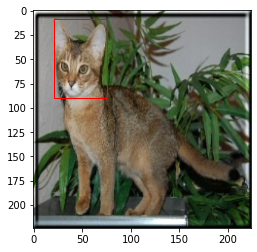

In [45]:
for img, label in train_dataset.take(1):
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    out1, out2, out3, out4 = label
    xmin, ymin, xmax, ymax = (out1[0]).numpy()*scal, (out2[0]).numpy()*scal, (out3[0]).numpy()*scal, (out4[0]).numpy()*scal
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)

In [46]:
xception = tf.keras.applications.Xception(weights='imagenet', 
                                          include_top=False,
                                          input_shape=(scal, scal, 3))

83697664/83683744 [==============================] - 0s 0us/step


In [47]:
inputs = tf.keras.layers.Input(shape=(scal, scal, 3))

x = xception(inputs)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

out1 = tf.keras.layers.Dense(1)(x)
out2 = tf.keras.layers.Dense(1)(x)
out3 = tf.keras.layers.Dense(1)(x)
out4 = tf.keras.layers.Dense(1)(x)

predictions = [out1, out2, out3, out4]

model = tf.keras.models.Model(inputs=inputs, outputs=predictions)

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='mse',
              metrics=['mae'])

In [49]:
EPOCHS = 50

In [50]:
history = model.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/50


2022-06-23 13:11:15.603463: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 57/368 [===>..........................] - ETA: 37s - loss: 0.1594 - dense_2_loss: 0.0338 - dense_3_loss: 0.0210 - dense_4_loss: 0.0592 - dense_5_loss: 0.0455 - dense_2_mae: 0.1460 - dense_3_mae: 0.1123 - dense_4_mae: 0.1853 - dense_5_mae: 0.1667

Corrupt JPEG data: premature end of data segment


 87/368 [======>.......................] - ETA: 34s - loss: 0.1381 - dense_2_loss: 0.0307 - dense_3_loss: 0.0192 - dense_4_loss: 0.0507 - dense_5_loss: 0.0375 - dense_2_mae: 0.1368 - dense_3_mae: 0.1070 - dense_4_mae: 0.1713 - dense_5_mae: 0.1490

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 63s 134ms/step - loss: 0.0801 - dense_2_loss: 0.0186 - dense_3_loss: 0.0121 - dense_4_loss: 0.0270 - dense_5_loss: 0.0224 - dense_2_mae: 0.1051 - dense_3_mae: 0.0843 - dense_4_mae: 0.1236 - dense_5_mae: 0.1141 - val_loss: 0.0925 - val_dense_2_loss: 0.0202 - val_dense_3_loss: 0.0111 - val_dense_4_loss: 0.0342 - val_dense_5_loss: 0.0270 - val_dense_2_mae: 0.1121 - val_dense_3_mae: 0.0851 - val_dense_4_mae: 0.1435 - val_dense_5_mae: 0.1311
Epoch 2/50
 57/368 [===>..........................] - ETA: 48s - loss: 0.0385 - dense_2_loss: 0.0085 - dense_3_loss: 0.0070 - dense_4_loss: 0.0128 - dense_5_loss: 0.0102 - dense_2_mae: 0.0732 - dense_3_mae: 0.0663 - dense_4_mae: 0.0902 - dense_5_mae: 0.0767

Corrupt JPEG data: premature end of data segment


 87/368 [======>.......................] - ETA: 40s - loss: 0.0376 - dense_2_loss: 0.0085 - dense_3_loss: 0.0067 - dense_4_loss: 0.0120 - dense_5_loss: 0.0104 - dense_2_mae: 0.0738 - dense_3_mae: 0.0646 - dense_4_mae: 0.0868 - dense_5_mae: 0.0779

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 52s 140ms/step - loss: 0.0320 - dense_2_loss: 0.0074 - dense_3_loss: 0.0059 - dense_4_loss: 0.0096 - dense_5_loss: 0.0091 - dense_2_mae: 0.0684 - dense_3_mae: 0.0600 - dense_4_mae: 0.0764 - dense_5_mae: 0.0742 - val_loss: 0.0372 - val_dense_2_loss: 0.0076 - val_dense_3_loss: 0.0073 - val_dense_4_loss: 0.0101 - val_dense_5_loss: 0.0121 - val_dense_2_mae: 0.0654 - val_dense_3_mae: 0.0694 - val_dense_4_mae: 0.0785 - val_dense_5_mae: 0.0828
Epoch 3/50
 56/368 [===>..........................] - ETA: 49s - loss: 0.0232 - dense_2_loss: 0.0057 - dense_3_loss: 0.0043 - dense_4_loss: 0.0066 - dense_5_loss: 0.0065 - dense_2_mae: 0.0601 - dense_3_mae: 0.0530 - dense_4_mae: 0.0655 - dense_5_mae: 0.0640

Corrupt JPEG data: premature end of data segment


 86/368 [======>.......................] - ETA: 41s - loss: 0.0234 - dense_2_loss: 0.0057 - dense_3_loss: 0.0043 - dense_4_loss: 0.0072 - dense_5_loss: 0.0062 - dense_2_mae: 0.0604 - dense_3_mae: 0.0523 - dense_4_mae: 0.0665 - dense_5_mae: 0.0636

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 52s 141ms/step - loss: 0.0196 - dense_2_loss: 0.0048 - dense_3_loss: 0.0038 - dense_4_loss: 0.0057 - dense_5_loss: 0.0053 - dense_2_mae: 0.0550 - dense_3_mae: 0.0484 - dense_4_mae: 0.0596 - dense_5_mae: 0.0578 - val_loss: 0.0220 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0032 - val_dense_4_loss: 0.0069 - val_dense_5_loss: 0.0075 - val_dense_2_mae: 0.0501 - val_dense_3_mae: 0.0432 - val_dense_4_mae: 0.0611 - val_dense_5_mae: 0.0665
Epoch 4/50
 57/368 [===>..........................] - ETA: 38s - loss: 0.0162 - dense_2_loss: 0.0038 - dense_3_loss: 0.0028 - dense_4_loss: 0.0050 - dense_5_loss: 0.0046 - dense_2_mae: 0.0485 - dense_3_mae: 0.0413 - dense_4_mae: 0.0550 - dense_5_mae: 0.0535

Corrupt JPEG data: premature end of data segment


 87/368 [======>.......................] - ETA: 34s - loss: 0.0166 - dense_2_loss: 0.0038 - dense_3_loss: 0.0028 - dense_4_loss: 0.0048 - dense_5_loss: 0.0052 - dense_2_mae: 0.0493 - dense_3_mae: 0.0419 - dense_4_mae: 0.0543 - dense_5_mae: 0.0564

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 0.0141 - dense_2_loss: 0.0033 - dense_3_loss: 0.0025 - dense_4_loss: 0.0041 - dense_5_loss: 0.0042 - dense_2_mae: 0.0458 - dense_3_mae: 0.0388 - dense_4_mae: 0.0502 - dense_5_mae: 0.0500 - val_loss: 0.0185 - val_dense_2_loss: 0.0036 - val_dense_3_loss: 0.0032 - val_dense_4_loss: 0.0055 - val_dense_5_loss: 0.0062 - val_dense_2_mae: 0.0439 - val_dense_3_mae: 0.0435 - val_dense_4_mae: 0.0548 - val_dense_5_mae: 0.0586
Epoch 5/50
 54/368 [===>..........................] - ETA: 50s - loss: 0.0126 - dense_2_loss: 0.0032 - dense_3_loss: 0.0022 - dense_4_loss: 0.0036 - dense_5_loss: 0.0036 - dense_2_mae: 0.0463 - dense_3_mae: 0.0354 - dense_4_mae: 0.0475 - dense_5_mae: 0.0462

Corrupt JPEG data: premature end of data segment


 84/368 [=====>........................] - ETA: 42s - loss: 0.0125 - dense_2_loss: 0.0032 - dense_3_loss: 0.0021 - dense_4_loss: 0.0036 - dense_5_loss: 0.0036 - dense_2_mae: 0.0463 - dense_3_mae: 0.0353 - dense_4_mae: 0.0472 - dense_5_mae: 0.0468

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 52s 142ms/step - loss: 0.0110 - dense_2_loss: 0.0028 - dense_3_loss: 0.0021 - dense_4_loss: 0.0032 - dense_5_loss: 0.0030 - dense_2_mae: 0.0418 - dense_3_mae: 0.0354 - dense_4_mae: 0.0444 - dense_5_mae: 0.0423 - val_loss: 0.0155 - val_dense_2_loss: 0.0037 - val_dense_3_loss: 0.0025 - val_dense_4_loss: 0.0041 - val_dense_5_loss: 0.0052 - val_dense_2_mae: 0.0433 - val_dense_3_mae: 0.0368 - val_dense_4_mae: 0.0474 - val_dense_5_mae: 0.0560
Epoch 6/50
 55/368 [===>..........................] - ETA: 38s - loss: 0.0116 - dense_2_loss: 0.0043 - dense_3_loss: 0.0017 - dense_4_loss: 0.0028 - dense_5_loss: 0.0028 - dense_2_mae: 0.0497 - dense_3_mae: 0.0317 - dense_4_mae: 0.0424 - dense_5_mae: 0.0429

Corrupt JPEG data: premature end of data segment


 85/368 [=====>........................] - ETA: 35s - loss: 0.0106 - dense_2_loss: 0.0035 - dense_3_loss: 0.0017 - dense_4_loss: 0.0025 - dense_5_loss: 0.0029 - dense_2_mae: 0.0450 - dense_3_mae: 0.0318 - dense_4_mae: 0.0403 - dense_5_mae: 0.0437

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0093 - dense_2_loss: 0.0024 - dense_3_loss: 0.0016 - dense_4_loss: 0.0027 - dense_5_loss: 0.0026 - dense_2_mae: 0.0376 - dense_3_mae: 0.0311 - dense_4_mae: 0.0407 - dense_5_mae: 0.0410 - val_loss: 0.0161 - val_dense_2_loss: 0.0038 - val_dense_3_loss: 0.0040 - val_dense_4_loss: 0.0042 - val_dense_5_loss: 0.0041 - val_dense_2_mae: 0.0446 - val_dense_3_mae: 0.0515 - val_dense_4_mae: 0.0468 - val_dense_5_mae: 0.0478
Epoch 7/50
 56/368 [===>..........................] - ETA: 38s - loss: 0.0073 - dense_2_loss: 0.0020 - dense_3_loss: 0.0014 - dense_4_loss: 0.0021 - dense_5_loss: 0.0019 - dense_2_mae: 0.0352 - dense_3_mae: 0.0293 - dense_4_mae: 0.0357 - dense_5_mae: 0.0340

Corrupt JPEG data: premature end of data segment


 86/368 [======>.......................] - ETA: 35s - loss: 0.0079 - dense_2_loss: 0.0021 - dense_3_loss: 0.0015 - dense_4_loss: 0.0020 - dense_5_loss: 0.0023 - dense_2_mae: 0.0362 - dense_3_mae: 0.0305 - dense_4_mae: 0.0359 - dense_5_mae: 0.0379

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 137ms/step - loss: 0.0075 - dense_2_loss: 0.0018 - dense_3_loss: 0.0015 - dense_4_loss: 0.0021 - dense_5_loss: 0.0022 - dense_2_mae: 0.0337 - dense_3_mae: 0.0303 - dense_4_mae: 0.0364 - dense_5_mae: 0.0368 - val_loss: 0.0093 - val_dense_2_loss: 0.0022 - val_dense_3_loss: 0.0015 - val_dense_4_loss: 0.0031 - val_dense_5_loss: 0.0025 - val_dense_2_mae: 0.0340 - val_dense_3_mae: 0.0286 - val_dense_4_mae: 0.0395 - val_dense_5_mae: 0.0358
Epoch 8/50
 57/368 [===>..........................] - ETA: 38s - loss: 0.0064 - dense_2_loss: 0.0014 - dense_3_loss: 0.0011 - dense_4_loss: 0.0019 - dense_5_loss: 0.0020 - dense_2_mae: 0.0307 - dense_3_mae: 0.0260 - dense_4_mae: 0.0344 - dense_5_mae: 0.0355

Corrupt JPEG data: premature end of data segment


 87/368 [======>.......................] - ETA: 34s - loss: 0.0063 - dense_2_loss: 0.0014 - dense_3_loss: 0.0013 - dense_4_loss: 0.0017 - dense_5_loss: 0.0019 - dense_2_mae: 0.0299 - dense_3_mae: 0.0279 - dense_4_mae: 0.0329 - dense_5_mae: 0.0344

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 0.0059 - dense_2_loss: 0.0014 - dense_3_loss: 0.0012 - dense_4_loss: 0.0017 - dense_5_loss: 0.0017 - dense_2_mae: 0.0297 - dense_3_mae: 0.0263 - dense_4_mae: 0.0320 - dense_5_mae: 0.0320 - val_loss: 0.0094 - val_dense_2_loss: 0.0027 - val_dense_3_loss: 0.0015 - val_dense_4_loss: 0.0029 - val_dense_5_loss: 0.0024 - val_dense_2_mae: 0.0378 - val_dense_3_mae: 0.0276 - val_dense_4_mae: 0.0378 - val_dense_5_mae: 0.0348
Epoch 9/50
 50/368 [===>..........................] - ETA: 48s - loss: 0.0047 - dense_2_loss: 0.0011 - dense_3_loss: 8.5329e-04 - dense_4_loss: 0.0014 - dense_5_loss: 0.0013 - dense_2_mae: 0.0267 - dense_3_mae: 0.0231 - dense_4_mae: 0.0287 - dense_5_mae: 0.0283

Corrupt JPEG data: premature end of data segment


 80/368 [=====>........................] - ETA: 41s - loss: 0.0049 - dense_2_loss: 0.0012 - dense_3_loss: 9.3993e-04 - dense_4_loss: 0.0014 - dense_5_loss: 0.0014 - dense_2_mae: 0.0270 - dense_3_mae: 0.0243 - dense_4_mae: 0.0294 - dense_5_mae: 0.0288

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 52s 141ms/step - loss: 0.0050 - dense_2_loss: 0.0012 - dense_3_loss: 0.0010 - dense_4_loss: 0.0014 - dense_5_loss: 0.0014 - dense_2_mae: 0.0266 - dense_3_mae: 0.0249 - dense_4_mae: 0.0296 - dense_5_mae: 0.0289 - val_loss: 0.0078 - val_dense_2_loss: 0.0021 - val_dense_3_loss: 0.0015 - val_dense_4_loss: 0.0022 - val_dense_5_loss: 0.0020 - val_dense_2_mae: 0.0331 - val_dense_3_mae: 0.0281 - val_dense_4_mae: 0.0330 - val_dense_5_mae: 0.0328
Epoch 10/50
 51/368 [===>..........................] - ETA: 39s - loss: 0.0043 - dense_2_loss: 9.8670e-04 - dense_3_loss: 8.0882e-04 - dense_4_loss: 0.0013 - dense_5_loss: 0.0012 - dense_2_mae: 0.0247 - dense_3_mae: 0.0223 - dense_4_mae: 0.0280 - dense_5_mae: 0.0276

Corrupt JPEG data: premature end of data segment


 81/368 [=====>........................] - ETA: 35s - loss: 0.0044 - dense_2_loss: 0.0010 - dense_3_loss: 8.1006e-04 - dense_4_loss: 0.0013 - dense_5_loss: 0.0012 - dense_2_mae: 0.0255 - dense_3_mae: 0.0227 - dense_4_mae: 0.0284 - dense_5_mae: 0.0270

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0042 - dense_2_loss: 9.2598e-04 - dense_3_loss: 7.5147e-04 - dense_4_loss: 0.0013 - dense_5_loss: 0.0012 - dense_2_mae: 0.0240 - dense_3_mae: 0.0215 - dense_4_mae: 0.0280 - dense_5_mae: 0.0270 - val_loss: 0.0074 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0020 - val_dense_5_loss: 0.0019 - val_dense_2_mae: 0.0344 - val_dense_3_mae: 0.0247 - val_dense_4_mae: 0.0309 - val_dense_5_mae: 0.0317
Epoch 11/50
 52/368 [===>..........................] - ETA: 38s - loss: 0.0046 - dense_2_loss: 8.7549e-04 - dense_3_loss: 7.4857e-04 - dense_4_loss: 0.0017 - dense_5_loss: 0.0013 - dense_2_mae: 0.0233 - dense_3_mae: 0.0208 - dense_4_mae: 0.0331 - dense_5_mae: 0.0284

Corrupt JPEG data: premature end of data segment


 82/368 [=====>........................] - ETA: 35s - loss: 0.0044 - dense_2_loss: 8.3919e-04 - dense_3_loss: 7.1923e-04 - dense_4_loss: 0.0016 - dense_5_loss: 0.0012 - dense_2_mae: 0.0230 - dense_3_mae: 0.0207 - dense_4_mae: 0.0318 - dense_5_mae: 0.0274

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 0.0039 - dense_2_loss: 7.6891e-04 - dense_3_loss: 6.7121e-04 - dense_4_loss: 0.0013 - dense_5_loss: 0.0012 - dense_2_mae: 0.0220 - dense_3_mae: 0.0200 - dense_4_mae: 0.0283 - dense_5_mae: 0.0267 - val_loss: 0.0070 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0018 - val_dense_5_loss: 0.0023 - val_dense_2_mae: 0.0299 - val_dense_3_mae: 0.0257 - val_dense_4_mae: 0.0297 - val_dense_5_mae: 0.0343
Epoch 12/50
 53/368 [===>..........................] - ETA: 40s - loss: 0.0036 - dense_2_loss: 8.2576e-04 - dense_3_loss: 5.7533e-04 - dense_4_loss: 0.0011 - dense_5_loss: 0.0011 - dense_2_mae: 0.0228 - dense_3_mae: 0.0189 - dense_4_mae: 0.0255 - dense_5_mae: 0.0253

Corrupt JPEG data: premature end of data segment


 83/368 [=====>........................] - ETA: 35s - loss: 0.0034 - dense_2_loss: 7.3405e-04 - dense_3_loss: 5.3001e-04 - dense_4_loss: 0.0011 - dense_5_loss: 0.0011 - dense_2_mae: 0.0214 - dense_3_mae: 0.0182 - dense_4_mae: 0.0256 - dense_5_mae: 0.0255

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 137ms/step - loss: 0.0036 - dense_2_loss: 8.0794e-04 - dense_3_loss: 5.9213e-04 - dense_4_loss: 0.0011 - dense_5_loss: 0.0011 - dense_2_mae: 0.0222 - dense_3_mae: 0.0190 - dense_4_mae: 0.0257 - dense_5_mae: 0.0255 - val_loss: 0.0065 - val_dense_2_loss: 0.0017 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0022 - val_dense_5_loss: 0.0015 - val_dense_2_mae: 0.0286 - val_dense_3_mae: 0.0239 - val_dense_4_mae: 0.0318 - val_dense_5_mae: 0.0278
Epoch 13/50
 54/368 [===>..........................] - ETA: 38s - loss: 0.0035 - dense_2_loss: 9.3661e-04 - dense_3_loss: 5.6448e-04 - dense_4_loss: 0.0011 - dense_5_loss: 8.7868e-04 - dense_2_mae: 0.0241 - dense_3_mae: 0.0188 - dense_4_mae: 0.0256 - dense_5_mae: 0.0226

Corrupt JPEG data: premature end of data segment


 84/368 [=====>........................] - ETA: 35s - loss: 0.0034 - dense_2_loss: 9.2336e-04 - dense_3_loss: 5.4126e-04 - dense_4_loss: 0.0010 - dense_5_loss: 8.9695e-04 - dense_2_mae: 0.0241 - dense_3_mae: 0.0181 - dense_4_mae: 0.0249 - dense_5_mae: 0.0229

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 137ms/step - loss: 0.0032 - dense_2_loss: 7.1301e-04 - dense_3_loss: 5.6986e-04 - dense_4_loss: 0.0010 - dense_5_loss: 9.1002e-04 - dense_2_mae: 0.0208 - dense_3_mae: 0.0184 - dense_4_mae: 0.0248 - dense_5_mae: 0.0232 - val_loss: 0.0064 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0010 - val_dense_4_loss: 0.0022 - val_dense_5_loss: 0.0016 - val_dense_2_mae: 0.0283 - val_dense_3_mae: 0.0231 - val_dense_4_mae: 0.0335 - val_dense_5_mae: 0.0295
Epoch 14/50
 55/368 [===>..........................] - ETA: 39s - loss: 0.0035 - dense_2_loss: 6.4962e-04 - dense_3_loss: 6.5303e-04 - dense_4_loss: 0.0011 - dense_5_loss: 0.0012 - dense_2_mae: 0.0200 - dense_3_mae: 0.0200 - dense_4_mae: 0.0253 - dense_5_mae: 0.0260

Corrupt JPEG data: premature end of data segment


 85/368 [=====>........................] - ETA: 35s - loss: 0.0035 - dense_2_loss: 6.4281e-04 - dense_3_loss: 7.4784e-04 - dense_4_loss: 9.6955e-04 - dense_5_loss: 0.0011 - dense_2_mae: 0.0198 - dense_3_mae: 0.0217 - dense_4_mae: 0.0243 - dense_5_mae: 0.0255

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 137ms/step - loss: 0.0031 - dense_2_loss: 6.4541e-04 - dense_3_loss: 5.5324e-04 - dense_4_loss: 8.7116e-04 - dense_5_loss: 9.8299e-04 - dense_2_mae: 0.0197 - dense_3_mae: 0.0182 - dense_4_mae: 0.0231 - dense_5_mae: 0.0241 - val_loss: 0.0070 - val_dense_2_loss: 0.0019 - val_dense_3_loss: 0.0010 - val_dense_4_loss: 0.0024 - val_dense_5_loss: 0.0016 - val_dense_2_mae: 0.0343 - val_dense_3_mae: 0.0235 - val_dense_4_mae: 0.0374 - val_dense_5_mae: 0.0289
Epoch 15/50
 56/368 [===>..........................] - ETA: 38s - loss: 0.0032 - dense_2_loss: 6.7426e-04 - dense_3_loss: 4.2515e-04 - dense_4_loss: 0.0011 - dense_5_loss: 9.9893e-04 - dense_2_mae: 0.0209 - dense_3_mae: 0.0161 - dense_4_mae: 0.0261 - dense_5_mae: 0.0253

Corrupt JPEG data: premature end of data segment


 86/368 [======>.......................] - ETA: 34s - loss: 0.0032 - dense_2_loss: 6.3948e-04 - dense_3_loss: 4.9429e-04 - dense_4_loss: 0.0011 - dense_5_loss: 9.3348e-04 - dense_2_mae: 0.0205 - dense_3_mae: 0.0175 - dense_4_mae: 0.0256 - dense_5_mae: 0.0241

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0029 - dense_2_loss: 5.9748e-04 - dense_3_loss: 4.5754e-04 - dense_4_loss: 9.5113e-04 - dense_5_loss: 8.8426e-04 - dense_2_mae: 0.0192 - dense_3_mae: 0.0166 - dense_4_mae: 0.0240 - dense_5_mae: 0.0235 - val_loss: 0.0052 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 8.7700e-04 - val_dense_4_loss: 0.0016 - val_dense_5_loss: 0.0013 - val_dense_2_mae: 0.0255 - val_dense_3_mae: 0.0212 - val_dense_4_mae: 0.0263 - val_dense_5_mae: 0.0260
Epoch 16/50
 57/368 [===>..........................] - ETA: 39s - loss: 0.0032 - dense_2_loss: 4.9715e-04 - dense_3_loss: 6.4362e-04 - dense_4_loss: 9.4609e-04 - dense_5_loss: 0.0011 - dense_2_mae: 0.0174 - dense_3_mae: 0.0198 - dense_4_mae: 0.0244 - dense_5_mae: 0.0261

Corrupt JPEG data: premature end of data segment


 87/368 [======>.......................] - ETA: 35s - loss: 0.0031 - dense_2_loss: 5.0843e-04 - dense_3_loss: 6.1232e-04 - dense_4_loss: 9.6733e-04 - dense_5_loss: 0.0010 - dense_2_mae: 0.0176 - dense_3_mae: 0.0194 - dense_4_mae: 0.0248 - dense_5_mae: 0.0248

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 0.0027 - dense_2_loss: 5.3364e-04 - dense_3_loss: 4.8548e-04 - dense_4_loss: 8.5295e-04 - dense_5_loss: 7.9513e-04 - dense_2_mae: 0.0180 - dense_3_mae: 0.0170 - dense_4_mae: 0.0229 - dense_5_mae: 0.0218 - val_loss: 0.0045 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 8.1834e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0013 - val_dense_2_mae: 0.0240 - val_dense_3_mae: 0.0203 - val_dense_4_mae: 0.0236 - val_dense_5_mae: 0.0258
Epoch 17/50
 42/368 [==>...........................] - ETA: 47s - loss: 0.0023 - dense_2_loss: 4.7303e-04 - dense_3_loss: 4.9087e-04 - dense_4_loss: 6.9892e-04 - dense_5_loss: 6.6400e-04 - dense_2_mae: 0.0169 - dense_3_mae: 0.0166 - dense_4_mae: 0.0208 - dense_5_mae: 0.0186

Corrupt JPEG data: premature end of data segment


 72/368 [====>.........................] - ETA: 40s - loss: 0.0025 - dense_2_loss: 5.1050e-04 - dense_3_loss: 4.8388e-04 - dense_4_loss: 7.8748e-04 - dense_5_loss: 7.2775e-04 - dense_2_mae: 0.0175 - dense_3_mae: 0.0168 - dense_4_mae: 0.0221 - dense_5_mae: 0.0201

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 51s 138ms/step - loss: 0.0023 - dense_2_loss: 4.9810e-04 - dense_3_loss: 3.9933e-04 - dense_4_loss: 7.4114e-04 - dense_5_loss: 6.8005e-04 - dense_2_mae: 0.0172 - dense_3_mae: 0.0155 - dense_4_mae: 0.0211 - dense_5_mae: 0.0199 - val_loss: 0.0045 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 7.8290e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0011 - val_dense_2_mae: 0.0250 - val_dense_3_mae: 0.0202 - val_dense_4_mae: 0.0238 - val_dense_5_mae: 0.0243
Epoch 18/50
 43/368 [==>...........................] - ETA: 41s - loss: 0.0018 - dense_2_loss: 3.8690e-04 - dense_3_loss: 3.5246e-04 - dense_4_loss: 5.0486e-04 - dense_5_loss: 5.7089e-04 - dense_2_mae: 0.0153 - dense_3_mae: 0.0145 - dense_4_mae: 0.0178 - dense_5_mae: 0.0187

Corrupt JPEG data: premature end of data segment


 73/368 [====>.........................] - ETA: 37s - loss: 0.0019 - dense_2_loss: 3.9539e-04 - dense_3_loss: 3.8279e-04 - dense_4_loss: 5.1292e-04 - dense_5_loss: 6.1799e-04 - dense_2_mae: 0.0153 - dense_3_mae: 0.0152 - dense_4_mae: 0.0179 - dense_5_mae: 0.0197

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0021 - dense_2_loss: 4.3787e-04 - dense_3_loss: 3.5486e-04 - dense_4_loss: 6.3144e-04 - dense_5_loss: 7.0987e-04 - dense_2_mae: 0.0162 - dense_3_mae: 0.0144 - dense_4_mae: 0.0196 - dense_5_mae: 0.0208 - val_loss: 0.0047 - val_dense_2_loss: 0.0015 - val_dense_3_loss: 7.3859e-04 - val_dense_4_loss: 0.0014 - val_dense_5_loss: 0.0011 - val_dense_2_mae: 0.0270 - val_dense_3_mae: 0.0201 - val_dense_4_mae: 0.0247 - val_dense_5_mae: 0.0250
Epoch 19/50
 44/368 [==>...........................] - ETA: 40s - loss: 0.0018 - dense_2_loss: 4.3833e-04 - dense_3_loss: 3.7994e-04 - dense_4_loss: 5.0628e-04 - dense_5_loss: 4.7555e-04 - dense_2_mae: 0.0169 - dense_3_mae: 0.0153 - dense_4_mae: 0.0169 - dense_5_mae: 0.0173

Corrupt JPEG data: premature end of data segment


 74/368 [=====>........................] - ETA: 36s - loss: 0.0018 - dense_2_loss: 4.4364e-04 - dense_3_loss: 3.6820e-04 - dense_4_loss: 5.0289e-04 - dense_5_loss: 4.9634e-04 - dense_2_mae: 0.0169 - dense_3_mae: 0.0148 - dense_4_mae: 0.0172 - dense_5_mae: 0.0174

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0019 - dense_2_loss: 4.2352e-04 - dense_3_loss: 3.2933e-04 - dense_4_loss: 5.4859e-04 - dense_5_loss: 5.6368e-04 - dense_2_mae: 0.0162 - dense_3_mae: 0.0140 - dense_4_mae: 0.0184 - dense_5_mae: 0.0183 - val_loss: 0.0056 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 6.8931e-04 - val_dense_4_loss: 0.0019 - val_dense_5_loss: 0.0014 - val_dense_2_mae: 0.0303 - val_dense_3_mae: 0.0200 - val_dense_4_mae: 0.0326 - val_dense_5_mae: 0.0282
Epoch 20/50
 45/368 [==>...........................] - ETA: 39s - loss: 0.0019 - dense_2_loss: 3.4804e-04 - dense_3_loss: 3.3057e-04 - dense_4_loss: 6.8796e-04 - dense_5_loss: 5.2621e-04 - dense_2_mae: 0.0145 - dense_3_mae: 0.0143 - dense_4_mae: 0.0201 - dense_5_mae: 0.0175

Corrupt JPEG data: premature end of data segment


 75/368 [=====>........................] - ETA: 36s - loss: 0.0018 - dense_2_loss: 4.2640e-04 - dense_3_loss: 2.9966e-04 - dense_4_loss: 5.7850e-04 - dense_5_loss: 4.9247e-04 - dense_2_mae: 0.0159 - dense_3_mae: 0.0133 - dense_4_mae: 0.0186 - dense_5_mae: 0.0174

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 0.0019 - dense_2_loss: 4.2514e-04 - dense_3_loss: 2.9022e-04 - dense_4_loss: 5.9160e-04 - dense_5_loss: 5.4810e-04 - dense_2_mae: 0.0159 - dense_3_mae: 0.0130 - dense_4_mae: 0.0187 - dense_5_mae: 0.0182 - val_loss: 0.0053 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 9.0002e-04 - val_dense_4_loss: 0.0016 - val_dense_5_loss: 0.0016 - val_dense_2_mae: 0.0228 - val_dense_3_mae: 0.0221 - val_dense_4_mae: 0.0279 - val_dense_5_mae: 0.0301
Epoch 21/50
 46/368 [==>...........................] - ETA: 39s - loss: 0.0023 - dense_2_loss: 5.1720e-04 - dense_3_loss: 4.0378e-04 - dense_4_loss: 6.1592e-04 - dense_5_loss: 7.2592e-04 - dense_2_mae: 0.0173 - dense_3_mae: 0.0147 - dense_4_mae: 0.0194 - dense_5_mae: 0.0200

Corrupt JPEG data: premature end of data segment


 76/368 [=====>........................] - ETA: 35s - loss: 0.0022 - dense_2_loss: 4.9920e-04 - dense_3_loss: 3.7836e-04 - dense_4_loss: 5.6036e-04 - dense_5_loss: 7.3062e-04 - dense_2_mae: 0.0173 - dense_3_mae: 0.0148 - dense_4_mae: 0.0187 - dense_5_mae: 0.0207

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 0.0019 - dense_2_loss: 4.1997e-04 - dense_3_loss: 3.2840e-04 - dense_4_loss: 5.3956e-04 - dense_5_loss: 6.1835e-04 - dense_2_mae: 0.0159 - dense_3_mae: 0.0139 - dense_4_mae: 0.0180 - dense_5_mae: 0.0190 - val_loss: 0.0053 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 8.9435e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0018 - val_dense_2_mae: 0.0270 - val_dense_3_mae: 0.0222 - val_dense_4_mae: 0.0240 - val_dense_5_mae: 0.0342
Epoch 22/50
 47/368 [==>...........................] - ETA: 38s - loss: 0.0015 - dense_2_loss: 3.8472e-04 - dense_3_loss: 2.5213e-04 - dense_4_loss: 4.3878e-04 - dense_5_loss: 4.6631e-04 - dense_2_mae: 0.0153 - dense_3_mae: 0.0125 - dense_4_mae: 0.0164 - dense_5_mae: 0.0172

Corrupt JPEG data: premature end of data segment


 77/368 [=====>........................] - ETA: 35s - loss: 0.0017 - dense_2_loss: 4.1948e-04 - dense_3_loss: 2.4537e-04 - dense_4_loss: 5.1867e-04 - dense_5_loss: 4.8189e-04 - dense_2_mae: 0.0162 - dense_3_mae: 0.0123 - dense_4_mae: 0.0178 - dense_5_mae: 0.0172

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 133ms/step - loss: 0.0016 - dense_2_loss: 4.2878e-04 - dense_3_loss: 2.4232e-04 - dense_4_loss: 4.6167e-04 - dense_5_loss: 4.8031e-04 - dense_2_mae: 0.0161 - dense_3_mae: 0.0122 - dense_4_mae: 0.0168 - dense_5_mae: 0.0168 - val_loss: 0.0040 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 6.7855e-04 - val_dense_4_loss: 0.0013 - val_dense_5_loss: 9.5144e-04 - val_dense_2_mae: 0.0216 - val_dense_3_mae: 0.0187 - val_dense_4_mae: 0.0243 - val_dense_5_mae: 0.0220
Epoch 23/50
 48/368 [==>...........................] - ETA: 39s - loss: 0.0017 - dense_2_loss: 3.8979e-04 - dense_3_loss: 2.4371e-04 - dense_4_loss: 5.8420e-04 - dense_5_loss: 5.0875e-04 - dense_2_mae: 0.0155 - dense_3_mae: 0.0118 - dense_4_mae: 0.0190 - dense_5_mae: 0.0176

Corrupt JPEG data: premature end of data segment


 78/368 [=====>........................] - ETA: 35s - loss: 0.0017 - dense_2_loss: 3.6859e-04 - dense_3_loss: 2.9490e-04 - dense_4_loss: 5.5903e-04 - dense_5_loss: 5.0063e-04 - dense_2_mae: 0.0151 - dense_3_mae: 0.0132 - dense_4_mae: 0.0187 - dense_5_mae: 0.0172

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0016 - dense_2_loss: 3.7895e-04 - dense_3_loss: 2.6983e-04 - dense_4_loss: 4.6334e-04 - dense_5_loss: 4.5352e-04 - dense_2_mae: 0.0150 - dense_3_mae: 0.0127 - dense_4_mae: 0.0168 - dense_5_mae: 0.0165 - val_loss: 0.0043 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 6.9128e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0011 - val_dense_2_mae: 0.0244 - val_dense_3_mae: 0.0187 - val_dense_4_mae: 0.0232 - val_dense_5_mae: 0.0248
Epoch 24/50
 49/368 [==>...........................] - ETA: 39s - loss: 0.0017 - dense_2_loss: 2.6525e-04 - dense_3_loss: 2.4517e-04 - dense_4_loss: 5.4087e-04 - dense_5_loss: 6.0473e-04 - dense_2_mae: 0.0126 - dense_3_mae: 0.0124 - dense_4_mae: 0.0186 - dense_5_mae: 0.0195

Corrupt JPEG data: premature end of data segment


 79/368 [=====>........................] - ETA: 35s - loss: 0.0019 - dense_2_loss: 3.0543e-04 - dense_3_loss: 2.5879e-04 - dense_4_loss: 7.1882e-04 - dense_5_loss: 6.2264e-04 - dense_2_mae: 0.0136 - dense_3_mae: 0.0124 - dense_4_mae: 0.0217 - dense_5_mae: 0.0200

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 0.0016 - dense_2_loss: 3.4889e-04 - dense_3_loss: 2.4313e-04 - dense_4_loss: 5.3475e-04 - dense_5_loss: 4.7710e-04 - dense_2_mae: 0.0143 - dense_3_mae: 0.0120 - dense_4_mae: 0.0180 - dense_5_mae: 0.0169 - val_loss: 0.0044 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 6.4343e-04 - val_dense_4_loss: 0.0016 - val_dense_5_loss: 0.0010 - val_dense_2_mae: 0.0224 - val_dense_3_mae: 0.0182 - val_dense_4_mae: 0.0268 - val_dense_5_mae: 0.0231
Epoch 25/50
 50/368 [===>..........................] - ETA: 39s - loss: 0.0018 - dense_2_loss: 3.1195e-04 - dense_3_loss: 3.6834e-04 - dense_4_loss: 4.6530e-04 - dense_5_loss: 6.7629e-04 - dense_2_mae: 0.0140 - dense_3_mae: 0.0143 - dense_4_mae: 0.0170 - dense_5_mae: 0.0194

Corrupt JPEG data: premature end of data segment


 80/368 [=====>........................] - ETA: 35s - loss: 0.0019 - dense_2_loss: 2.9288e-04 - dense_3_loss: 3.0207e-04 - dense_4_loss: 5.9143e-04 - dense_5_loss: 7.5398e-04 - dense_2_mae: 0.0135 - dense_3_mae: 0.0131 - dense_4_mae: 0.0187 - dense_5_mae: 0.0208

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 51s 138ms/step - loss: 0.0016 - dense_2_loss: 3.1849e-04 - dense_3_loss: 2.9052e-04 - dense_4_loss: 4.6910e-04 - dense_5_loss: 5.2283e-04 - dense_2_mae: 0.0136 - dense_3_mae: 0.0132 - dense_4_mae: 0.0167 - dense_5_mae: 0.0173 - val_loss: 0.0043 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 8.6527e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 0.0010 - val_dense_2_mae: 0.0233 - val_dense_3_mae: 0.0193 - val_dense_4_mae: 0.0217 - val_dense_5_mae: 0.0224
Epoch 26/50
 51/368 [===>..........................] - ETA: 39s - loss: 0.0013 - dense_2_loss: 2.8929e-04 - dense_3_loss: 2.0788e-04 - dense_4_loss: 4.1568e-04 - dense_5_loss: 3.4188e-04 - dense_2_mae: 0.0133 - dense_3_mae: 0.0110 - dense_4_mae: 0.0154 - dense_5_mae: 0.0140

Corrupt JPEG data: premature end of data segment


 81/368 [=====>........................] - ETA: 35s - loss: 0.0013 - dense_2_loss: 2.8365e-04 - dense_3_loss: 2.2146e-04 - dense_4_loss: 4.5564e-04 - dense_5_loss: 3.5061e-04 - dense_2_mae: 0.0132 - dense_3_mae: 0.0114 - dense_4_mae: 0.0166 - dense_5_mae: 0.0143

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0014 - dense_2_loss: 2.8163e-04 - dense_3_loss: 2.2762e-04 - dense_4_loss: 4.6061e-04 - dense_5_loss: 3.9414e-04 - dense_2_mae: 0.0131 - dense_3_mae: 0.0116 - dense_4_mae: 0.0166 - dense_5_mae: 0.0154 - val_loss: 0.0037 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 6.4766e-04 - val_dense_4_loss: 0.0010 - val_dense_5_loss: 9.8124e-04 - val_dense_2_mae: 0.0216 - val_dense_3_mae: 0.0175 - val_dense_4_mae: 0.0204 - val_dense_5_mae: 0.0217
Epoch 27/50
 52/368 [===>..........................] - ETA: 39s - loss: 0.0012 - dense_2_loss: 2.4316e-04 - dense_3_loss: 1.7829e-04 - dense_4_loss: 3.5956e-04 - dense_5_loss: 3.7143e-04 - dense_2_mae: 0.0121 - dense_3_mae: 0.0105 - dense_4_mae: 0.0150 - dense_5_mae: 0.0149

Corrupt JPEG data: premature end of data segment


 82/368 [=====>........................] - ETA: 35s - loss: 0.0011 - dense_2_loss: 2.2703e-04 - dense_3_loss: 1.6819e-04 - dense_4_loss: 3.3095e-04 - dense_5_loss: 3.3686e-04 - dense_2_mae: 0.0115 - dense_3_mae: 0.0102 - dense_4_mae: 0.0144 - dense_5_mae: 0.0141

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 51s 139ms/step - loss: 0.0013 - dense_2_loss: 2.6742e-04 - dense_3_loss: 1.9834e-04 - dense_4_loss: 3.9033e-04 - dense_5_loss: 4.2453e-04 - dense_2_mae: 0.0126 - dense_3_mae: 0.0110 - dense_4_mae: 0.0154 - dense_5_mae: 0.0157 - val_loss: 0.0050 - val_dense_2_loss: 0.0019 - val_dense_3_loss: 6.9312e-04 - val_dense_4_loss: 0.0013 - val_dense_5_loss: 0.0011 - val_dense_2_mae: 0.0342 - val_dense_3_mae: 0.0186 - val_dense_4_mae: 0.0220 - val_dense_5_mae: 0.0227
Epoch 28/50
 53/368 [===>..........................] - ETA: 38s - loss: 0.0012 - dense_2_loss: 2.3025e-04 - dense_3_loss: 1.8718e-04 - dense_4_loss: 4.3010e-04 - dense_5_loss: 3.5892e-04 - dense_2_mae: 0.0118 - dense_3_mae: 0.0102 - dense_4_mae: 0.0164 - dense_5_mae: 0.0151

Corrupt JPEG data: premature end of data segment


 83/368 [=====>........................] - ETA: 34s - loss: 0.0013 - dense_2_loss: 2.5575e-04 - dense_3_loss: 2.1345e-04 - dense_4_loss: 4.1243e-04 - dense_5_loss: 4.2500e-04 - dense_2_mae: 0.0124 - dense_3_mae: 0.0110 - dense_4_mae: 0.0160 - dense_5_mae: 0.0162

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0012 - dense_2_loss: 2.4022e-04 - dense_3_loss: 2.2563e-04 - dense_4_loss: 3.3384e-04 - dense_5_loss: 4.0793e-04 - dense_2_mae: 0.0120 - dense_3_mae: 0.0115 - dense_4_mae: 0.0141 - dense_5_mae: 0.0157 - val_loss: 0.0039 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 6.9101e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 9.2474e-04 - val_dense_2_mae: 0.0224 - val_dense_3_mae: 0.0185 - val_dense_4_mae: 0.0204 - val_dense_5_mae: 0.0219
Epoch 29/50
 54/368 [===>..........................] - ETA: 38s - loss: 0.0011 - dense_2_loss: 3.3112e-04 - dense_3_loss: 2.3771e-04 - dense_4_loss: 3.1314e-04 - dense_5_loss: 2.6092e-04 - dense_2_mae: 0.0143 - dense_3_mae: 0.0119 - dense_4_mae: 0.0141 - dense_5_mae: 0.0128

Corrupt JPEG data: premature end of data segment


 84/368 [=====>........................] - ETA: 36s - loss: 0.0012 - dense_2_loss: 2.9154e-04 - dense_3_loss: 2.2859e-04 - dense_4_loss: 4.1556e-04 - dense_5_loss: 2.9870e-04 - dense_2_mae: 0.0133 - dense_3_mae: 0.0117 - dense_4_mae: 0.0161 - dense_5_mae: 0.0135

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 137ms/step - loss: 0.0012 - dense_2_loss: 2.5371e-04 - dense_3_loss: 1.9503e-04 - dense_4_loss: 3.8193e-04 - dense_5_loss: 3.7007e-04 - dense_2_mae: 0.0125 - dense_3_mae: 0.0108 - dense_4_mae: 0.0155 - dense_5_mae: 0.0151 - val_loss: 0.0041 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 7.1120e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 9.9190e-04 - val_dense_2_mae: 0.0207 - val_dense_3_mae: 0.0185 - val_dense_4_mae: 0.0208 - val_dense_5_mae: 0.0217
Epoch 30/50
 55/368 [===>..........................] - ETA: 38s - loss: 9.2472e-04 - dense_2_loss: 2.3401e-04 - dense_3_loss: 2.0317e-04 - dense_4_loss: 2.6274e-04 - dense_5_loss: 2.2480e-04 - dense_2_mae: 0.0117 - dense_3_mae: 0.0106 - dense_4_mae: 0.0128 - dense_5_mae: 0.0113

Corrupt JPEG data: premature end of data segment


 85/368 [=====>........................] - ETA: 34s - loss: 9.3234e-04 - dense_2_loss: 2.0727e-04 - dense_3_loss: 2.0952e-04 - dense_4_loss: 2.9812e-04 - dense_5_loss: 2.1742e-04 - dense_2_mae: 0.0111 - dense_3_mae: 0.0110 - dense_4_mae: 0.0137 - dense_5_mae: 0.0112

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 136ms/step - loss: 0.0011 - dense_2_loss: 2.3037e-04 - dense_3_loss: 1.9875e-04 - dense_4_loss: 3.3976e-04 - dense_5_loss: 3.6841e-04 - dense_2_mae: 0.0118 - dense_3_mae: 0.0109 - dense_4_mae: 0.0144 - dense_5_mae: 0.0147 - val_loss: 0.0034 - val_dense_2_loss: 8.6946e-04 - val_dense_3_loss: 6.4457e-04 - val_dense_4_loss: 9.7957e-04 - val_dense_5_loss: 8.5719e-04 - val_dense_2_mae: 0.0200 - val_dense_3_mae: 0.0177 - val_dense_4_mae: 0.0195 - val_dense_5_mae: 0.0213
Epoch 31/50
 56/368 [===>..........................] - ETA: 39s - loss: 0.0013 - dense_2_loss: 2.6464e-04 - dense_3_loss: 2.0384e-04 - dense_4_loss: 2.9687e-04 - dense_5_loss: 4.9296e-04 - dense_2_mae: 0.0127 - dense_3_mae: 0.0108 - dense_4_mae: 0.0134 - dense_5_mae: 0.0175

Corrupt JPEG data: premature end of data segment


 86/368 [======>.......................] - ETA: 35s - loss: 0.0012 - dense_2_loss: 2.4141e-04 - dense_3_loss: 1.9495e-04 - dense_4_loss: 2.8710e-04 - dense_5_loss: 4.2862e-04 - dense_2_mae: 0.0120 - dense_3_mae: 0.0106 - dense_4_mae: 0.0131 - dense_5_mae: 0.0162

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 137ms/step - loss: 0.0011 - dense_2_loss: 2.4721e-04 - dense_3_loss: 1.7416e-04 - dense_4_loss: 3.0301e-04 - dense_5_loss: 3.3513e-04 - dense_2_mae: 0.0122 - dense_3_mae: 0.0102 - dense_4_mae: 0.0136 - dense_5_mae: 0.0141 - val_loss: 0.0037 - val_dense_2_loss: 9.3656e-04 - val_dense_3_loss: 5.4871e-04 - val_dense_4_loss: 0.0014 - val_dense_5_loss: 8.2915e-04 - val_dense_2_mae: 0.0198 - val_dense_3_mae: 0.0162 - val_dense_4_mae: 0.0260 - val_dense_5_mae: 0.0203
Epoch 32/50
 57/368 [===>..........................] - ETA: 38s - loss: 9.7884e-04 - dense_2_loss: 1.9932e-04 - dense_3_loss: 1.2886e-04 - dense_4_loss: 2.6581e-04 - dense_5_loss: 3.8484e-04 - dense_2_mae: 0.0108 - dense_3_mae: 0.0089 - dense_4_mae: 0.0127 - dense_5_mae: 0.0155

Corrupt JPEG data: premature end of data segment


 87/368 [======>.......................] - ETA: 34s - loss: 0.0010 - dense_2_loss: 2.2380e-04 - dense_3_loss: 1.3210e-04 - dense_4_loss: 3.1117e-04 - dense_5_loss: 3.7686e-04 - dense_2_mae: 0.0115 - dense_3_mae: 0.0089 - dense_4_mae: 0.0140 - dense_5_mae: 0.0153

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 0.0011 - dense_2_loss: 2.4097e-04 - dense_3_loss: 1.6924e-04 - dense_4_loss: 3.2723e-04 - dense_5_loss: 3.3260e-04 - dense_2_mae: 0.0120 - dense_3_mae: 0.0101 - dense_4_mae: 0.0141 - dense_5_mae: 0.0142 - val_loss: 0.0034 - val_dense_2_loss: 9.6176e-04 - val_dense_3_loss: 5.6151e-04 - val_dense_4_loss: 9.4950e-04 - val_dense_5_loss: 9.4783e-04 - val_dense_2_mae: 0.0216 - val_dense_3_mae: 0.0163 - val_dense_4_mae: 0.0205 - val_dense_5_mae: 0.0226
Epoch 33/50
 58/368 [===>..........................] - ETA: 39s - loss: 8.8930e-04 - dense_2_loss: 2.0418e-04 - dense_3_loss: 1.5447e-04 - dense_4_loss: 2.6419e-04 - dense_5_loss: 2.6647e-04 - dense_2_mae: 0.0115 - dense_3_mae: 0.0099 - dense_4_mae: 0.0125 - dense_5_mae: 0.0125

Corrupt JPEG data: premature end of data segment


 88/368 [======>.......................] - ETA: 35s - loss: 8.4973e-04 - dense_2_loss: 2.0072e-04 - dense_3_loss: 1.4112e-04 - dense_4_loss: 2.5641e-04 - dense_5_loss: 2.5149e-04 - dense_2_mae: 0.0111 - dense_3_mae: 0.0093 - dense_4_mae: 0.0123 - dense_5_mae: 0.0123

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 9.7489e-04 - dense_2_loss: 2.2879e-04 - dense_3_loss: 1.9228e-04 - dense_4_loss: 2.7289e-04 - dense_5_loss: 2.8093e-04 - dense_2_mae: 0.0117 - dense_3_mae: 0.0105 - dense_4_mae: 0.0128 - dense_5_mae: 0.0133 - val_loss: 0.0037 - val_dense_2_loss: 9.7771e-04 - val_dense_3_loss: 7.8313e-04 - val_dense_4_loss: 0.0010 - val_dense_5_loss: 9.1206e-04 - val_dense_2_mae: 0.0195 - val_dense_3_mae: 0.0185 - val_dense_4_mae: 0.0208 - val_dense_5_mae: 0.0206
Epoch 34/50
 59/368 [===>..........................] - ETA: 38s - loss: 7.9384e-04 - dense_2_loss: 1.6941e-04 - dense_3_loss: 1.4484e-04 - dense_4_loss: 1.8642e-04 - dense_5_loss: 2.9318e-04 - dense_2_mae: 0.0103 - dense_3_mae: 0.0092 - dense_4_mae: 0.0107 - dense_5_mae: 0.0133

Corrupt JPEG data: premature end of data segment


 89/368 [======>.......................] - ETA: 34s - loss: 8.3198e-04 - dense_2_loss: 1.7939e-04 - dense_3_loss: 1.5439e-04 - dense_4_loss: 2.1425e-04 - dense_5_loss: 2.8396e-04 - dense_2_mae: 0.0106 - dense_3_mae: 0.0096 - dense_4_mae: 0.0113 - dense_5_mae: 0.0133

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 8.9919e-04 - dense_2_loss: 2.3026e-04 - dense_3_loss: 1.5933e-04 - dense_4_loss: 2.3969e-04 - dense_5_loss: 2.6991e-04 - dense_2_mae: 0.0119 - dense_3_mae: 0.0096 - dense_4_mae: 0.0120 - dense_5_mae: 0.0127 - val_loss: 0.0037 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 5.6329e-04 - val_dense_4_loss: 0.0010 - val_dense_5_loss: 9.8454e-04 - val_dense_2_mae: 0.0194 - val_dense_3_mae: 0.0158 - val_dense_4_mae: 0.0188 - val_dense_5_mae: 0.0204
Epoch 35/50
 60/368 [===>..........................] - ETA: 38s - loss: 7.9414e-04 - dense_2_loss: 1.5978e-04 - dense_3_loss: 1.5919e-04 - dense_4_loss: 2.8123e-04 - dense_5_loss: 1.9393e-04 - dense_2_mae: 0.0097 - dense_3_mae: 0.0098 - dense_4_mae: 0.0131 - dense_5_mae: 0.0107

Corrupt JPEG data: premature end of data segment


 90/368 [======>.......................] - ETA: 34s - loss: 7.8165e-04 - dense_2_loss: 1.4953e-04 - dense_3_loss: 1.5270e-04 - dense_4_loss: 2.6953e-04 - dense_5_loss: 2.0989e-04 - dense_2_mae: 0.0093 - dense_3_mae: 0.0095 - dense_4_mae: 0.0127 - dense_5_mae: 0.0112

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 8.1164e-04 - dense_2_loss: 1.9061e-04 - dense_3_loss: 1.5012e-04 - dense_4_loss: 2.4291e-04 - dense_5_loss: 2.2800e-04 - dense_2_mae: 0.0106 - dense_3_mae: 0.0094 - dense_4_mae: 0.0122 - dense_5_mae: 0.0116 - val_loss: 0.0038 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 6.0459e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 9.4845e-04 - val_dense_2_mae: 0.0195 - val_dense_3_mae: 0.0164 - val_dense_4_mae: 0.0228 - val_dense_5_mae: 0.0202
Epoch 36/50
 61/368 [===>..........................] - ETA: 38s - loss: 8.3180e-04 - dense_2_loss: 1.8361e-04 - dense_3_loss: 1.0471e-04 - dense_4_loss: 3.1770e-04 - dense_5_loss: 2.2577e-04 - dense_2_mae: 0.0105 - dense_3_mae: 0.0078 - dense_4_mae: 0.0140 - dense_5_mae: 0.0116

Corrupt JPEG data: premature end of data segment


 91/368 [======>.......................] - ETA: 34s - loss: 8.0720e-04 - dense_2_loss: 1.6961e-04 - dense_3_loss: 1.0560e-04 - dense_4_loss: 3.0902e-04 - dense_5_loss: 2.2298e-04 - dense_2_mae: 0.0100 - dense_3_mae: 0.0079 - dense_4_mae: 0.0138 - dense_5_mae: 0.0114

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 135ms/step - loss: 7.9799e-04 - dense_2_loss: 1.9160e-04 - dense_3_loss: 1.3915e-04 - dense_4_loss: 2.4863e-04 - dense_5_loss: 2.1860e-04 - dense_2_mae: 0.0107 - dense_3_mae: 0.0091 - dense_4_mae: 0.0123 - dense_5_mae: 0.0114 - val_loss: 0.0039 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 6.7859e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 8.5943e-04 - val_dense_2_mae: 0.0214 - val_dense_3_mae: 0.0173 - val_dense_4_mae: 0.0189 - val_dense_5_mae: 0.0198
Epoch 37/50
 62/368 [====>.........................] - ETA: 38s - loss: 6.4793e-04 - dense_2_loss: 1.8572e-04 - dense_3_loss: 9.0695e-05 - dense_4_loss: 2.2487e-04 - dense_5_loss: 1.4665e-04 - dense_2_mae: 0.0106 - dense_3_mae: 0.0075 - dense_4_mae: 0.0117 - dense_5_mae: 0.0095

Corrupt JPEG data: premature end of data segment


 92/368 [======>.......................] - ETA: 34s - loss: 6.8650e-04 - dense_2_loss: 2.0707e-04 - dense_3_loss: 9.2270e-05 - dense_4_loss: 2.2052e-04 - dense_5_loss: 1.6664e-04 - dense_2_mae: 0.0113 - dense_3_mae: 0.0076 - dense_4_mae: 0.0117 - dense_5_mae: 0.0099

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 8.1908e-04 - dense_2_loss: 2.1301e-04 - dense_3_loss: 1.3847e-04 - dense_4_loss: 2.3787e-04 - dense_5_loss: 2.2974e-04 - dense_2_mae: 0.0111 - dense_3_mae: 0.0090 - dense_4_mae: 0.0120 - dense_5_mae: 0.0114 - val_loss: 0.0044 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 8.5584e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0010 - val_dense_2_mae: 0.0228 - val_dense_3_mae: 0.0190 - val_dense_4_mae: 0.0192 - val_dense_5_mae: 0.0206
Epoch 38/50
 63/368 [====>.........................] - ETA: 38s - loss: 7.2300e-04 - dense_2_loss: 1.9484e-04 - dense_3_loss: 1.2885e-04 - dense_4_loss: 2.1282e-04 - dense_5_loss: 1.8648e-04 - dense_2_mae: 0.0108 - dense_3_mae: 0.0087 - dense_4_mae: 0.0114 - dense_5_mae: 0.0107

Corrupt JPEG data: premature end of data segment


 93/368 [======>.......................] - ETA: 34s - loss: 7.3248e-04 - dense_2_loss: 2.0801e-04 - dense_3_loss: 1.2276e-04 - dense_4_loss: 2.2216e-04 - dense_5_loss: 1.7956e-04 - dense_2_mae: 0.0111 - dense_3_mae: 0.0085 - dense_4_mae: 0.0117 - dense_5_mae: 0.0104

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 7.3670e-04 - dense_2_loss: 1.7961e-04 - dense_3_loss: 1.2568e-04 - dense_4_loss: 2.2643e-04 - dense_5_loss: 2.0497e-04 - dense_2_mae: 0.0104 - dense_3_mae: 0.0085 - dense_4_mae: 0.0118 - dense_5_mae: 0.0110 - val_loss: 0.0037 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 5.5845e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 9.0239e-04 - val_dense_2_mae: 0.0193 - val_dense_3_mae: 0.0159 - val_dense_4_mae: 0.0197 - val_dense_5_mae: 0.0209
Epoch 39/50
 64/368 [====>.........................] - ETA: 37s - loss: 8.4788e-04 - dense_2_loss: 1.7583e-04 - dense_3_loss: 1.5058e-04 - dense_4_loss: 2.4339e-04 - dense_5_loss: 2.7808e-04 - dense_2_mae: 0.0103 - dense_3_mae: 0.0095 - dense_4_mae: 0.0124 - dense_5_mae: 0.0131

Corrupt JPEG data: premature end of data segment


 94/368 [======>.......................] - ETA: 34s - loss: 8.7321e-04 - dense_2_loss: 1.9303e-04 - dense_3_loss: 1.6007e-04 - dense_4_loss: 2.2966e-04 - dense_5_loss: 2.9045e-04 - dense_2_mae: 0.0110 - dense_3_mae: 0.0097 - dense_4_mae: 0.0119 - dense_5_mae: 0.0135

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 7.6903e-04 - dense_2_loss: 1.8405e-04 - dense_3_loss: 1.3387e-04 - dense_4_loss: 2.0461e-04 - dense_5_loss: 2.4650e-04 - dense_2_mae: 0.0105 - dense_3_mae: 0.0090 - dense_4_mae: 0.0111 - dense_5_mae: 0.0121 - val_loss: 0.0035 - val_dense_2_loss: 8.3364e-04 - val_dense_3_loss: 5.2958e-04 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 9.4432e-04 - val_dense_2_mae: 0.0184 - val_dense_3_mae: 0.0161 - val_dense_4_mae: 0.0245 - val_dense_5_mae: 0.0194
Epoch 40/50
 65/368 [====>.........................] - ETA: 38s - loss: 8.0073e-04 - dense_2_loss: 1.3688e-04 - dense_3_loss: 1.2077e-04 - dense_4_loss: 3.1777e-04 - dense_5_loss: 2.2532e-04 - dense_2_mae: 0.0090 - dense_3_mae: 0.0082 - dense_4_mae: 0.0133 - dense_5_mae: 0.0114

Corrupt JPEG data: premature end of data segment


 95/368 [======>.......................] - ETA: 34s - loss: 8.5344e-04 - dense_2_loss: 1.5162e-04 - dense_3_loss: 1.4702e-04 - dense_4_loss: 2.9839e-04 - dense_5_loss: 2.5641e-04 - dense_2_mae: 0.0095 - dense_3_mae: 0.0092 - dense_4_mae: 0.0131 - dense_5_mae: 0.0122

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 8.1404e-04 - dense_2_loss: 1.6303e-04 - dense_3_loss: 1.2396e-04 - dense_4_loss: 2.5638e-04 - dense_5_loss: 2.7067e-04 - dense_2_mae: 0.0100 - dense_3_mae: 0.0086 - dense_4_mae: 0.0123 - dense_5_mae: 0.0128 - val_loss: 0.0036 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 5.4966e-04 - val_dense_4_loss: 0.0010 - val_dense_5_loss: 9.1182e-04 - val_dense_2_mae: 0.0205 - val_dense_3_mae: 0.0160 - val_dense_4_mae: 0.0203 - val_dense_5_mae: 0.0193
Epoch 41/50
 66/368 [====>.........................] - ETA: 37s - loss: 7.5034e-04 - dense_2_loss: 1.4377e-04 - dense_3_loss: 9.3075e-05 - dense_4_loss: 2.6394e-04 - dense_5_loss: 2.4956e-04 - dense_2_mae: 0.0091 - dense_3_mae: 0.0075 - dense_4_mae: 0.0126 - dense_5_mae: 0.0121

Corrupt JPEG data: premature end of data segment


 96/368 [======>.......................] - ETA: 33s - loss: 7.1909e-04 - dense_2_loss: 1.4372e-04 - dense_3_loss: 1.0120e-04 - dense_4_loss: 2.3568e-04 - dense_5_loss: 2.3849e-04 - dense_2_mae: 0.0093 - dense_3_mae: 0.0079 - dense_4_mae: 0.0118 - dense_5_mae: 0.0118

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 135ms/step - loss: 7.9325e-04 - dense_2_loss: 1.9153e-04 - dense_3_loss: 1.1545e-04 - dense_4_loss: 2.4065e-04 - dense_5_loss: 2.4562e-04 - dense_2_mae: 0.0108 - dense_3_mae: 0.0083 - dense_4_mae: 0.0120 - dense_5_mae: 0.0120 - val_loss: 0.0033 - val_dense_2_loss: 8.6055e-04 - val_dense_3_loss: 5.9775e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 7.7712e-04 - val_dense_2_mae: 0.0181 - val_dense_3_mae: 0.0180 - val_dense_4_mae: 0.0206 - val_dense_5_mae: 0.0187
Epoch 42/50
 67/368 [====>.........................] - ETA: 37s - loss: 7.2117e-04 - dense_2_loss: 1.4511e-04 - dense_3_loss: 8.7233e-05 - dense_4_loss: 2.4593e-04 - dense_5_loss: 2.4290e-04 - dense_2_mae: 0.0096 - dense_3_mae: 0.0075 - dense_4_mae: 0.0125 - dense_5_mae: 0.0121

Corrupt JPEG data: premature end of data segment


 97/368 [======>.......................] - ETA: 33s - loss: 6.9045e-04 - dense_2_loss: 1.5771e-04 - dense_3_loss: 9.1896e-05 - dense_4_loss: 2.1867e-04 - dense_5_loss: 2.2217e-04 - dense_2_mae: 0.0100 - dense_3_mae: 0.0076 - dense_4_mae: 0.0117 - dense_5_mae: 0.0115

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 6.7417e-04 - dense_2_loss: 1.6329e-04 - dense_3_loss: 9.9376e-05 - dense_4_loss: 1.9788e-04 - dense_5_loss: 2.1362e-04 - dense_2_mae: 0.0099 - dense_3_mae: 0.0078 - dense_4_mae: 0.0110 - dense_5_mae: 0.0113 - val_loss: 0.0033 - val_dense_2_loss: 9.5210e-04 - val_dense_3_loss: 6.5764e-04 - val_dense_4_loss: 8.8597e-04 - val_dense_5_loss: 8.3959e-04 - val_dense_2_mae: 0.0188 - val_dense_3_mae: 0.0154 - val_dense_4_mae: 0.0178 - val_dense_5_mae: 0.0191
Epoch 43/50
 68/368 [====>.........................] - ETA: 37s - loss: 5.5182e-04 - dense_2_loss: 1.3568e-04 - dense_3_loss: 9.2728e-05 - dense_4_loss: 1.3307e-04 - dense_5_loss: 1.9033e-04 - dense_2_mae: 0.0094 - dense_3_mae: 0.0076 - dense_4_mae: 0.0088 - dense_5_mae: 0.0108

Corrupt JPEG data: premature end of data segment


 98/368 [======>.......................] - ETA: 33s - loss: 5.7412e-04 - dense_2_loss: 1.3762e-04 - dense_3_loss: 1.0275e-04 - dense_4_loss: 1.5029e-04 - dense_5_loss: 1.8346e-04 - dense_2_mae: 0.0093 - dense_3_mae: 0.0079 - dense_4_mae: 0.0093 - dense_5_mae: 0.0104

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 7.2929e-04 - dense_2_loss: 1.6313e-04 - dense_3_loss: 1.0905e-04 - dense_4_loss: 2.3222e-04 - dense_5_loss: 2.2490e-04 - dense_2_mae: 0.0098 - dense_3_mae: 0.0082 - dense_4_mae: 0.0117 - dense_5_mae: 0.0116 - val_loss: 0.0037 - val_dense_2_loss: 8.9188e-04 - val_dense_3_loss: 6.0245e-04 - val_dense_4_loss: 0.0013 - val_dense_5_loss: 9.6143e-04 - val_dense_2_mae: 0.0177 - val_dense_3_mae: 0.0153 - val_dense_4_mae: 0.0230 - val_dense_5_mae: 0.0210
Epoch 44/50
 69/368 [====>.........................] - ETA: 37s - loss: 6.9895e-04 - dense_2_loss: 1.2576e-04 - dense_3_loss: 1.4512e-04 - dense_4_loss: 1.5686e-04 - dense_5_loss: 2.7121e-04 - dense_2_mae: 0.0089 - dense_3_mae: 0.0094 - dense_4_mae: 0.0098 - dense_5_mae: 0.0129

Corrupt JPEG data: premature end of data segment


 99/368 [=======>......................] - ETA: 33s - loss: 7.0006e-04 - dense_2_loss: 1.2548e-04 - dense_3_loss: 1.3652e-04 - dense_4_loss: 1.7562e-04 - dense_5_loss: 2.6244e-04 - dense_2_mae: 0.0090 - dense_3_mae: 0.0090 - dense_4_mae: 0.0104 - dense_5_mae: 0.0127

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 6.5139e-04 - dense_2_loss: 1.5414e-04 - dense_3_loss: 1.0916e-04 - dense_4_loss: 1.9264e-04 - dense_5_loss: 1.9545e-04 - dense_2_mae: 0.0097 - dense_3_mae: 0.0080 - dense_4_mae: 0.0109 - dense_5_mae: 0.0108 - val_loss: 0.0035 - val_dense_2_loss: 9.5100e-04 - val_dense_3_loss: 6.3831e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 8.3058e-04 - val_dense_2_mae: 0.0183 - val_dense_3_mae: 0.0159 - val_dense_4_mae: 0.0180 - val_dense_5_mae: 0.0195
Epoch 45/50
 70/368 [====>.........................] - ETA: 36s - loss: 7.1681e-04 - dense_2_loss: 1.2421e-04 - dense_3_loss: 8.5687e-05 - dense_4_loss: 2.1809e-04 - dense_5_loss: 2.8883e-04 - dense_2_mae: 0.0087 - dense_3_mae: 0.0068 - dense_4_mae: 0.0117 - dense_5_mae: 0.0137

Corrupt JPEG data: premature end of data segment


100/368 [=======>......................] - ETA: 33s - loss: 6.6645e-04 - dense_2_loss: 1.1978e-04 - dense_3_loss: 1.0921e-04 - dense_4_loss: 1.9321e-04 - dense_5_loss: 2.4425e-04 - dense_2_mae: 0.0086 - dense_3_mae: 0.0078 - dense_4_mae: 0.0109 - dense_5_mae: 0.0124

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 5.9776e-04 - dense_2_loss: 1.4503e-04 - dense_3_loss: 9.5285e-05 - dense_4_loss: 1.7720e-04 - dense_5_loss: 1.8025e-04 - dense_2_mae: 0.0093 - dense_3_mae: 0.0074 - dense_4_mae: 0.0102 - dense_5_mae: 0.0104 - val_loss: 0.0039 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 7.7786e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 8.9240e-04 - val_dense_2_mae: 0.0194 - val_dense_3_mae: 0.0162 - val_dense_4_mae: 0.0183 - val_dense_5_mae: 0.0190
Epoch 46/50
 71/368 [====>.........................] - ETA: 36s - loss: 4.7497e-04 - dense_2_loss: 1.0795e-04 - dense_3_loss: 8.4212e-05 - dense_4_loss: 1.4263e-04 - dense_5_loss: 1.4018e-04 - dense_2_mae: 0.0082 - dense_3_mae: 0.0071 - dense_4_mae: 0.0093 - dense_5_mae: 0.0093

Corrupt JPEG data: premature end of data segment


101/368 [=======>......................] - ETA: 33s - loss: 4.9053e-04 - dense_2_loss: 1.0993e-04 - dense_3_loss: 8.7130e-05 - dense_4_loss: 1.4613e-04 - dense_5_loss: 1.4735e-04 - dense_2_mae: 0.0083 - dense_3_mae: 0.0073 - dense_4_mae: 0.0094 - dense_5_mae: 0.0095

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 5.5799e-04 - dense_2_loss: 1.3513e-04 - dense_3_loss: 9.0838e-05 - dense_4_loss: 1.6564e-04 - dense_5_loss: 1.6639e-04 - dense_2_mae: 0.0090 - dense_3_mae: 0.0074 - dense_4_mae: 0.0100 - dense_5_mae: 0.0100 - val_loss: 0.0037 - val_dense_2_loss: 0.0010 - val_dense_3_loss: 6.0460e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 9.3708e-04 - val_dense_2_mae: 0.0198 - val_dense_3_mae: 0.0152 - val_dense_4_mae: 0.0201 - val_dense_5_mae: 0.0205
Epoch 47/50
 72/368 [====>.........................] - ETA: 36s - loss: 5.3335e-04 - dense_2_loss: 1.3635e-04 - dense_3_loss: 8.3971e-05 - dense_4_loss: 1.8014e-04 - dense_5_loss: 1.3289e-04 - dense_2_mae: 0.0091 - dense_3_mae: 0.0069 - dense_4_mae: 0.0107 - dense_5_mae: 0.0091

Corrupt JPEG data: premature end of data segment


102/368 [=======>......................] - ETA: 33s - loss: 5.2521e-04 - dense_2_loss: 1.2776e-04 - dense_3_loss: 8.6656e-05 - dense_4_loss: 1.6472e-04 - dense_5_loss: 1.4607e-04 - dense_2_mae: 0.0087 - dense_3_mae: 0.0071 - dense_4_mae: 0.0101 - dense_5_mae: 0.0092

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 5.0774e-04 - dense_2_loss: 1.1745e-04 - dense_3_loss: 8.3423e-05 - dense_4_loss: 1.5386e-04 - dense_5_loss: 1.5301e-04 - dense_2_mae: 0.0085 - dense_3_mae: 0.0070 - dense_4_mae: 0.0097 - dense_5_mae: 0.0095 - val_loss: 0.0031 - val_dense_2_loss: 8.7488e-04 - val_dense_3_loss: 5.5694e-04 - val_dense_4_loss: 9.0592e-04 - val_dense_5_loss: 7.4176e-04 - val_dense_2_mae: 0.0179 - val_dense_3_mae: 0.0147 - val_dense_4_mae: 0.0180 - val_dense_5_mae: 0.0182
Epoch 48/50
 73/368 [====>.........................] - ETA: 36s - loss: 5.5905e-04 - dense_2_loss: 1.1916e-04 - dense_3_loss: 8.8261e-05 - dense_4_loss: 1.5939e-04 - dense_5_loss: 1.9225e-04 - dense_2_mae: 0.0084 - dense_3_mae: 0.0071 - dense_4_mae: 0.0100 - dense_5_mae: 0.0108

Corrupt JPEG data: premature end of data segment


103/368 [=======>......................] - ETA: 32s - loss: 5.7720e-04 - dense_2_loss: 1.3472e-04 - dense_3_loss: 1.0438e-04 - dense_4_loss: 1.5857e-04 - dense_5_loss: 1.7954e-04 - dense_2_mae: 0.0091 - dense_3_mae: 0.0078 - dense_4_mae: 0.0100 - dense_5_mae: 0.0104

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 4.5887e-04 - dense_2_loss: 1.1285e-04 - dense_3_loss: 8.8122e-05 - dense_4_loss: 1.2138e-04 - dense_5_loss: 1.3652e-04 - dense_2_mae: 0.0082 - dense_3_mae: 0.0072 - dense_4_mae: 0.0087 - dense_5_mae: 0.0090 - val_loss: 0.0032 - val_dense_2_loss: 8.5815e-04 - val_dense_3_loss: 6.2501e-04 - val_dense_4_loss: 9.2215e-04 - val_dense_5_loss: 8.2308e-04 - val_dense_2_mae: 0.0190 - val_dense_3_mae: 0.0166 - val_dense_4_mae: 0.0188 - val_dense_5_mae: 0.0185
Epoch 49/50
 74/368 [=====>........................] - ETA: 36s - loss: 4.4786e-04 - dense_2_loss: 1.0138e-04 - dense_3_loss: 7.3847e-05 - dense_4_loss: 1.0873e-04 - dense_5_loss: 1.6391e-04 - dense_2_mae: 0.0077 - dense_3_mae: 0.0065 - dense_4_mae: 0.0082 - dense_5_mae: 0.0102

Corrupt JPEG data: premature end of data segment


104/368 [=======>......................] - ETA: 32s - loss: 4.8919e-04 - dense_2_loss: 1.0435e-04 - dense_3_loss: 8.7540e-05 - dense_4_loss: 1.1496e-04 - dense_5_loss: 1.8233e-04 - dense_2_mae: 0.0078 - dense_3_mae: 0.0072 - dense_4_mae: 0.0085 - dense_5_mae: 0.0106

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 49s 134ms/step - loss: 4.8755e-04 - dense_2_loss: 1.1467e-04 - dense_3_loss: 9.9409e-05 - dense_4_loss: 1.2447e-04 - dense_5_loss: 1.4900e-04 - dense_2_mae: 0.0083 - dense_3_mae: 0.0077 - dense_4_mae: 0.0086 - dense_5_mae: 0.0095 - val_loss: 0.0030 - val_dense_2_loss: 7.8762e-04 - val_dense_3_loss: 4.9746e-04 - val_dense_4_loss: 8.7015e-04 - val_dense_5_loss: 8.4931e-04 - val_dense_2_mae: 0.0173 - val_dense_3_mae: 0.0145 - val_dense_4_mae: 0.0183 - val_dense_5_mae: 0.0190
Epoch 50/50
 75/368 [=====>........................] - ETA: 37s - loss: 5.3193e-04 - dense_2_loss: 1.6397e-04 - dense_3_loss: 8.3028e-05 - dense_4_loss: 1.2724e-04 - dense_5_loss: 1.5769e-04 - dense_2_mae: 0.0101 - dense_3_mae: 0.0070 - dense_4_mae: 0.0088 - dense_5_mae: 0.0098

Corrupt JPEG data: premature end of data segment


105/368 [=======>......................] - ETA: 33s - loss: 5.4348e-04 - dense_2_loss: 1.4483e-04 - dense_3_loss: 9.1205e-05 - dense_4_loss: 1.2961e-04 - dense_5_loss: 1.7784e-04 - dense_2_mae: 0.0094 - dense_3_mae: 0.0074 - dense_4_mae: 0.0089 - dense_5_mae: 0.0105

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


368/368 [==============================] - 50s 135ms/step - loss: 5.0008e-04 - dense_2_loss: 1.2741e-04 - dense_3_loss: 9.1469e-05 - dense_4_loss: 1.3286e-04 - dense_5_loss: 1.4834e-04 - dense_2_mae: 0.0088 - dense_3_mae: 0.0074 - dense_4_mae: 0.0091 - dense_5_mae: 0.0095 - val_loss: 0.0032 - val_dense_2_loss: 8.1786e-04 - val_dense_3_loss: 4.8458e-04 - val_dense_4_loss: 0.0011 - val_dense_5_loss: 8.2875e-04 - val_dense_2_mae: 0.0178 - val_dense_3_mae: 0.0146 - val_dense_4_mae: 0.0225 - val_dense_5_mae: 0.0195


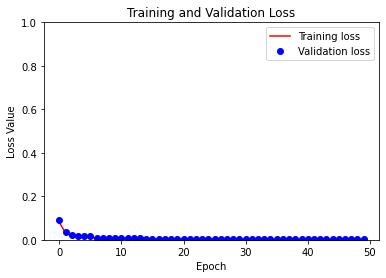

In [51]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [52]:
model.save('detect_v1.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [53]:
new_model = tf.keras.models.load_model('./detect_v1.h5')

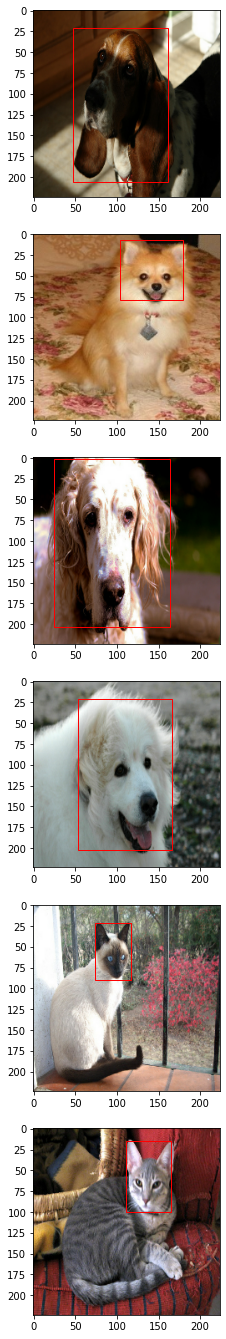

In [54]:
plt.figure(figsize=(8, 24))
for img, _ in test_dataset.take(1):
    out1, out2, out3, out4 = new_model.predict(img)
    for i in range(6):
        plt.subplot(6, 1, i+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        xmin, ymin, xmax, ymax = out1[i]*224, out2[i]*224, out3[i]*224, out4[i]*224,
        rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
        ax = plt.gca()
        ax.axes.add_patch(rect)